In [552]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn import tree # for text representation
from matplotlib import pyplot as plt

import dtreeviz
from supertree import SuperTree

#### data

In [666]:
segmentation_st = pd.read_sas("data_for_segmentation_st.sas7bdat")
segmentation_mw = pd.read_sas("data_for_segmentation_wi.sas7bdat")

In [ ]:
#odstranění nepotřebných sloupců (původní produktové proměnné)
segmentation_mw = segmentation_mw.drop(["C_100100","C_100110","C_100120","C_100140","C_100160"], axis=1)

In [668]:
segmentation_st = segmentation_st.drop(["CBSMessageId","Exclusion"],axis=1)
segmentation_mw = segmentation_mw.drop(["CBSMessageId","Exclusion"],axis=1)

#### bytes to strings

In [669]:
#převod bytes to strings
columns_to_convert = ["C_600570","C_660570","C_500300","C_500600","C_501200","C_502400","performance"]
def convert_bytes_to_str(x):
    return x.decode('utf-8') if isinstance(x, bytes) else x
segmentation_st[columns_to_convert] = segmentation_st[columns_to_convert].map(convert_bytes_to_str)
segmentation_mw[columns_to_convert] = segmentation_mw[columns_to_convert].map(convert_bytes_to_str)

#### NaN

In [ ]:
#fill NaNs
categorical_columns = segmentation_mw.select_dtypes(include=['object']).columns
performance_columns = ["C_500300","C_501200","C_500600","C_502400"]
numeric_columns = segmentation_mw.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
#kategorické proměnné NaN -> nejčastější hodnota
cat_imputer = SimpleImputer(strategy='most_frequent')
segmentation_mw[categorical_columns] = cat_imputer.fit_transform(segmentation_mw[categorical_columns])

In [ ]:
#numerické proměnné NaN -> -999
segmentation_mw[numeric_columns] = segmentation_mw[numeric_columns].fillna(-999)

In [673]:
#vytvoření kopie datasetu, dále hlavní dataset 'df_imp'
df_imp = segmentation_mw.copy()

#### Encoding

In [ ]:
#kódování kategorických proměnných (bez performance)
label_encoders = {}
for column in df_imp.columns:
    if df_imp[column].dtype == 'object' and column not in performance_columns:
        le = LabelEncoder()
        df_imp[column] = le.fit_transform(df_imp[column])
        label_encoders[column] = le

In [ ]:
#kódování performance proměnných
mapping = {'B': 2, 'I': 1, 'G': 0}
for col in performance_columns:
    df_imp[col] = df_imp[col].map(mapping)

#### Úvodní Train, test split

In [676]:
train,test = train_test_split(df_imp, test_size = 0.3, random_state = 42)

In [ ]:
#backups
test_backup = test.copy()
train_backup = train.copy()

### DT Model na všech datech

#### Model

In [678]:
X = train.drop('performance', axis = 1)
y = train['performance']

In [679]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

#### Visualisation

In [475]:
text_representation = tree.export_text(clf,
                                       feature_names = list(clf.feature_names_in_),
                                       show_weights = True)
print(text_representation)

|--- C_750100 <= 2.50
|   |--- C_502400 <= 0.50
|   |   |--- C_107480 <= 36.95
|   |   |   |--- weights: [5551.00, 124498.00] class: 1
|   |   |--- C_107480 >  36.95
|   |   |   |--- weights: [2849.00, 145932.00] class: 1
|   |--- C_502400 >  0.50
|   |   |--- C_111640 <= 0.50
|   |   |   |--- weights: [2622.00, 22661.00] class: 1
|   |   |--- C_111640 >  0.50
|   |   |   |--- weights: [2063.00, 6959.00] class: 1
|--- C_750100 >  2.50
|   |--- weights: [5484.00, 1126.00] class: 0



#### Tree plot

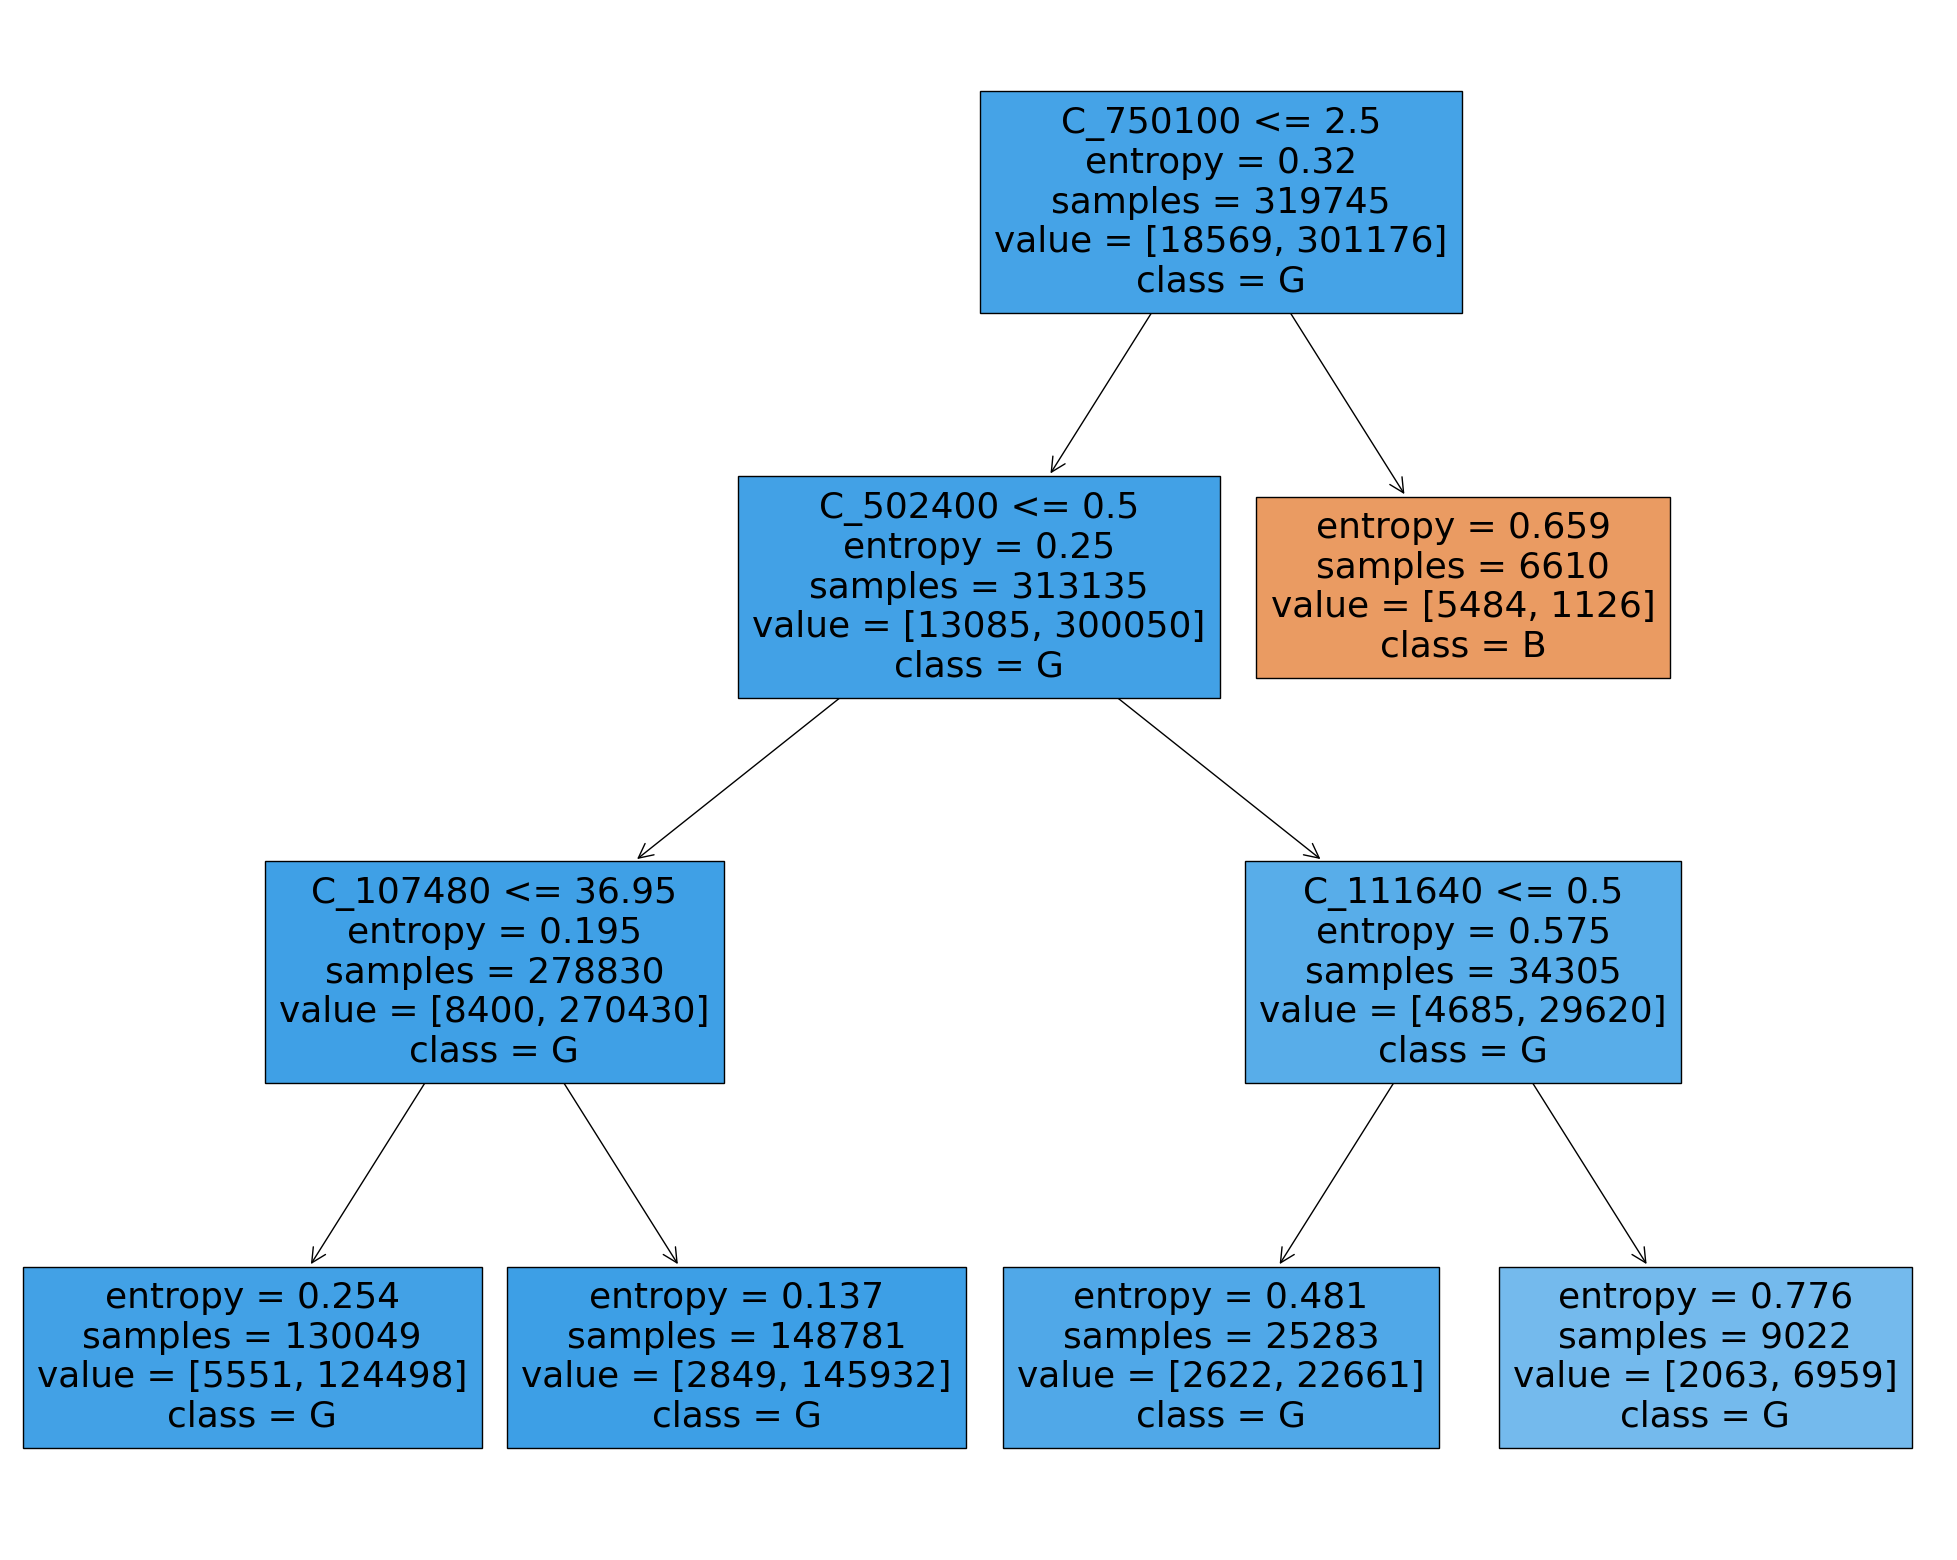

In [680]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)

# fig.savefig("decistion_tree.png")

#### Model - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

#### A) na všech datech

In [682]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
rf.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

In [683]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

#### B) bez performance proměnných
přeskočit k vizualizaci, pokud chceme použít všechny sloupce

In [ ]:
# without performance cols - all_performance_cols
all_performance_cols = ["C_111640","C_111660","C_111620","C_111600","C_111500","C_500300","C_501200","C_502400","C_751200","C_750600","C_750100","C_752400","C_750300", "C_500600", "C_106920","performance"]

X = train.drop(all_performance_cols, axis = 1)
y = train['performance']

In [ ]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
rf.fit(X,y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

#### C) no seg 1 and seg 2
přeskočit k vizualizaci, pokud chceme použít všechny sloupce

In [ ]:
#df_imp_3_step
X = train_no_s1_no_s2.drop('performance', axis = 1)
y = train_no_s1_no_s2['performance']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 42)

rf = RandomForestClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

#### Vizualizace

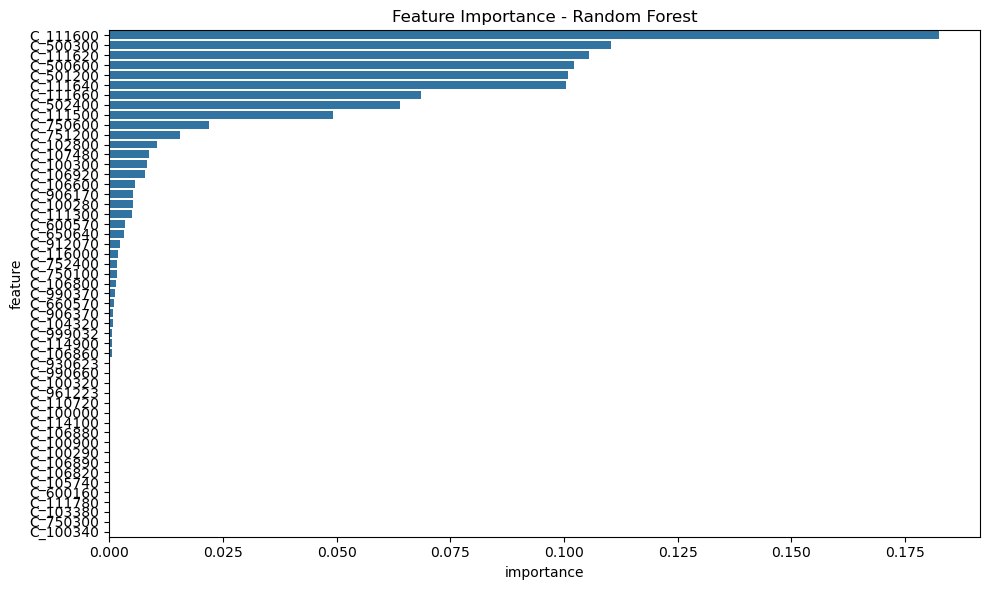

In [ ]:
#tento kód je společný pro různé typy datasetů (A, B, C)
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

#### Feature importance based on mean decrease in impurity

In [685]:
importance = rf.feature_importances_
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

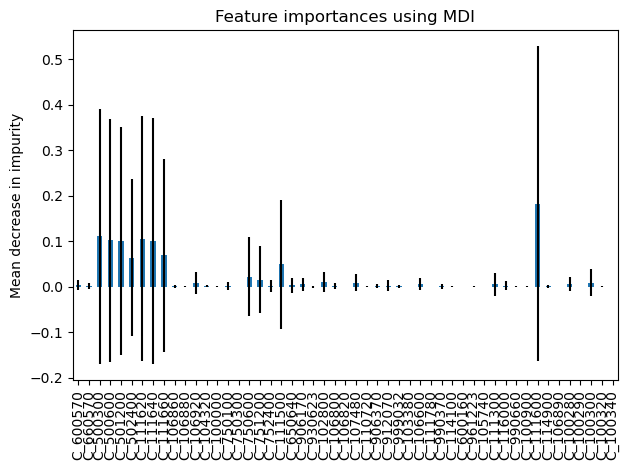

In [686]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [687]:
forest_importances = pd.Series(importance, index=feature_names)
df_importances = forest_importances.to_frame(name = 'importance')
df_importances.sort_values(by = 'importance', ascending=False)

,importance
C_111600,0.182339
C_500300,0.110302
C_111620,0.105489
C_500600,0.102136
C_501200,0.100842
C_111640,0.100441
C_111660,0.068647
C_502400,0.063945
C_111500,0.049188
C_750600,0.022024


#### DT pouze s jednou performance proměnnou "C_500600"

In [ ]:
# vyhodit performance proměnné, nechat 1 ("C_500600") a spustit decision trees
# výběr sloupců
performance_cols = ["C_111640","C_111660","C_111620","C_111600","C_111500","C_500300","C_501200","C_502400","C_751200","C_750600","C_750100","C_752400","C_750300","C_106920"]
train_no_perf = train.drop(performance_cols, axis = 1)

In [689]:
X = train_no_perf.drop('performance', axis = 1)
y = train_no_perf['performance']

In [690]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

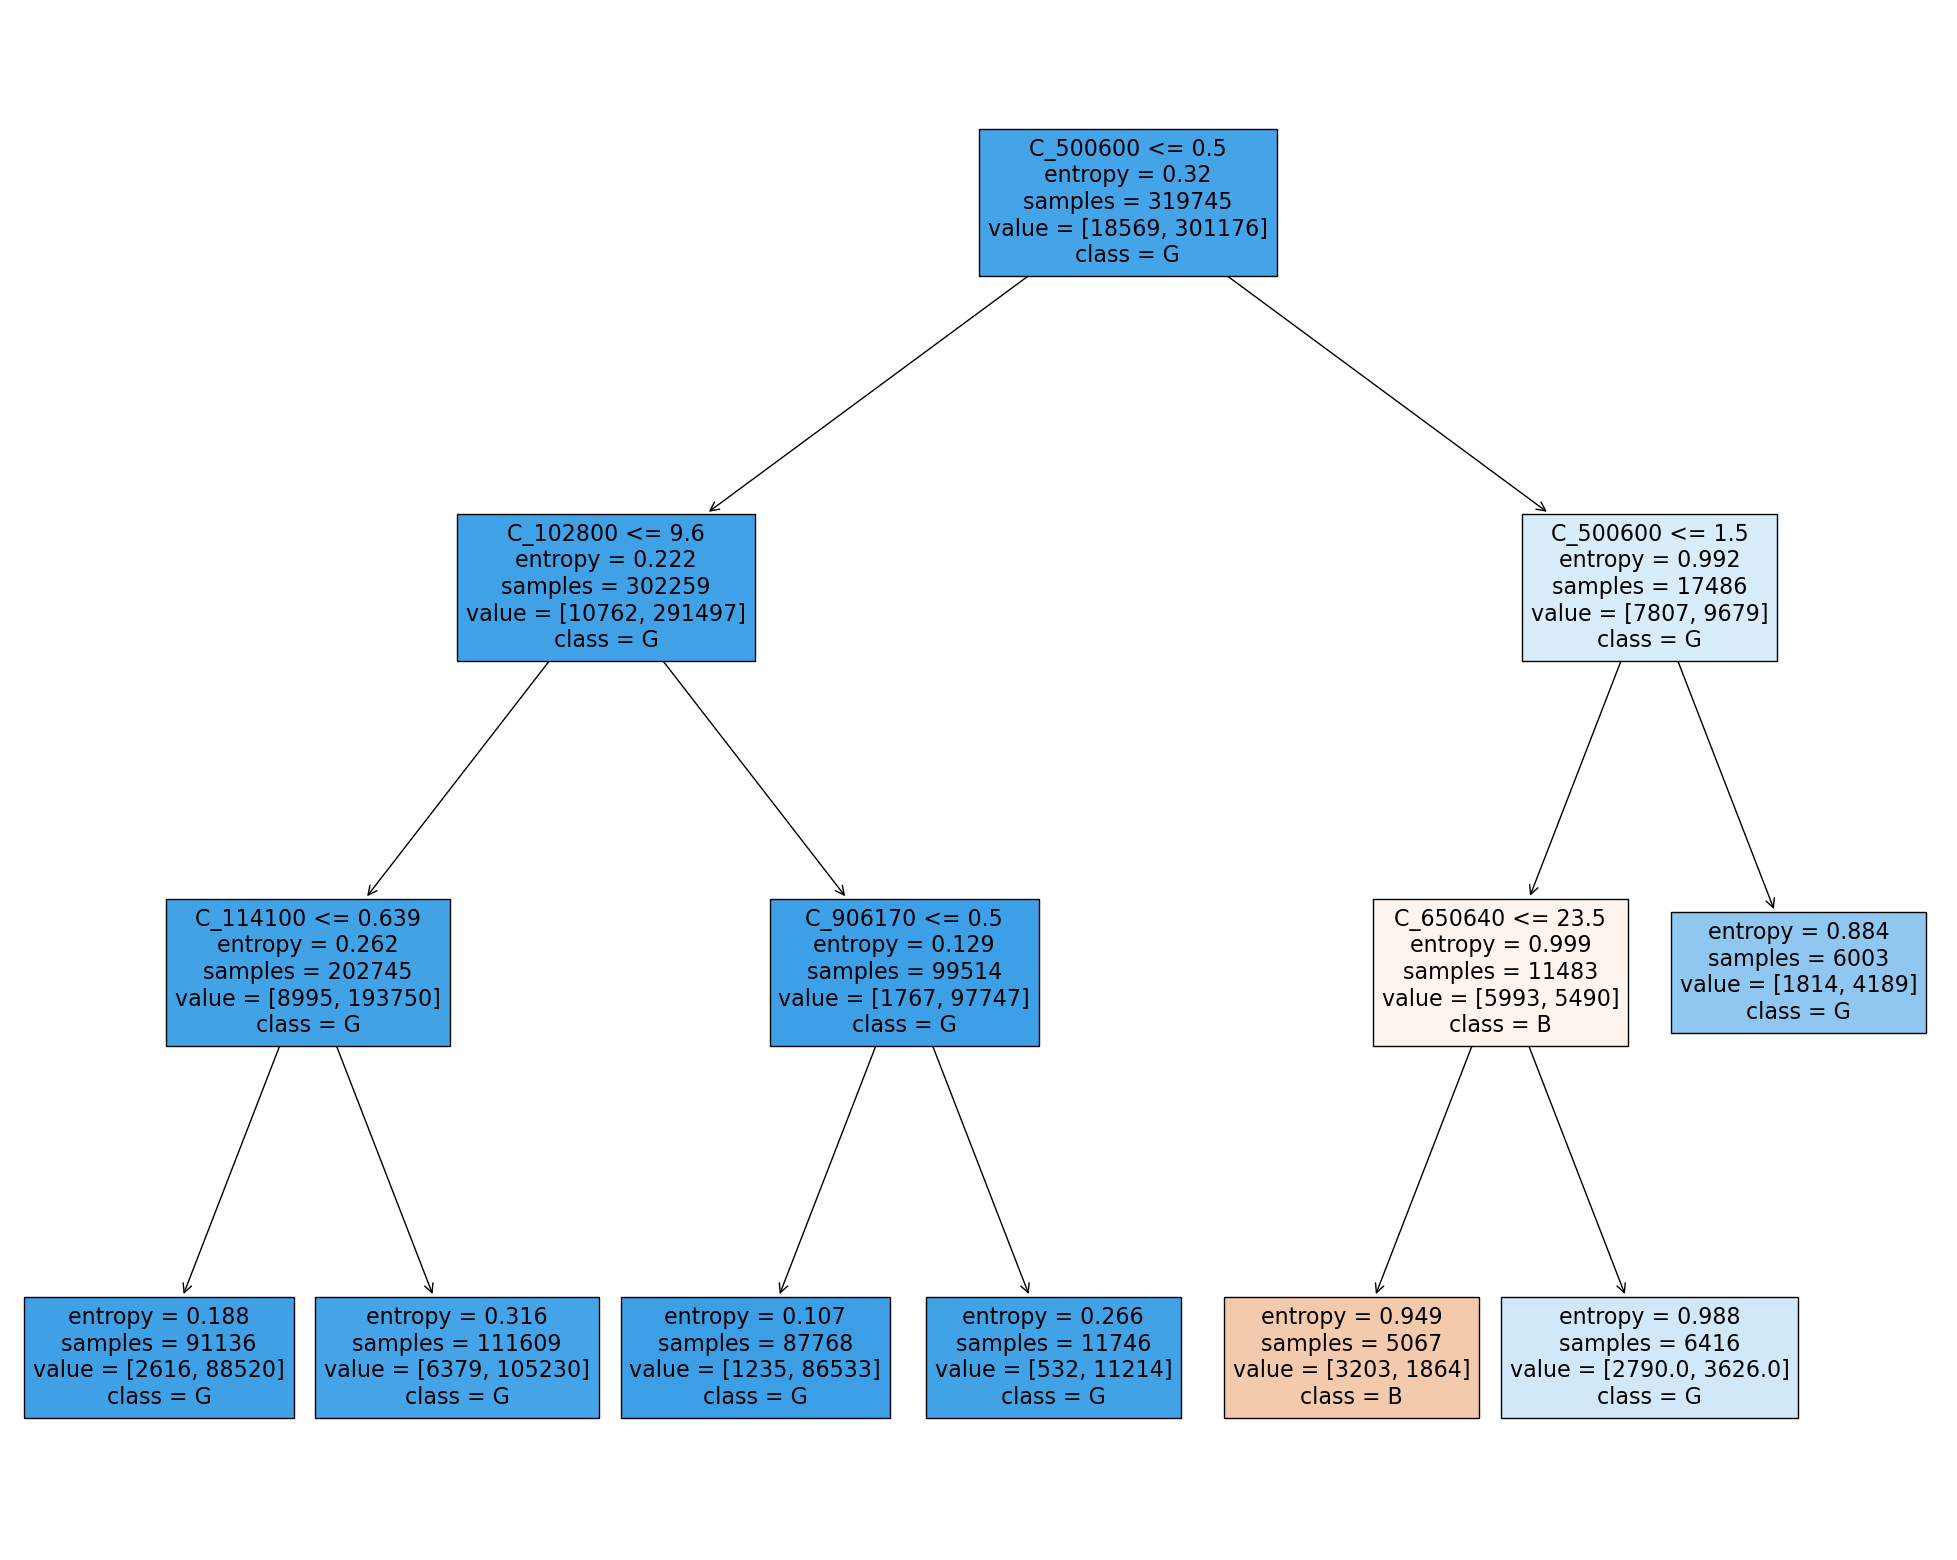

In [691]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)


In [692]:
text_representation = tree.export_text(clf,
                                       feature_names = list(clf.feature_names_in_),
                                       show_weights = True)
print(text_representation)

|--- C_500600 <= 0.50
|   |--- C_102800 <= 9.60
|   |   |--- C_114100 <= 0.64
|   |   |   |--- weights: [2616.00, 88520.00] class: 1
|   |   |--- C_114100 >  0.64
|   |   |   |--- weights: [6379.00, 105230.00] class: 1
|   |--- C_102800 >  9.60
|   |   |--- C_906170 <= 0.50
|   |   |   |--- weights: [1235.00, 86533.00] class: 1
|   |   |--- C_906170 >  0.50
|   |   |   |--- weights: [532.00, 11214.00] class: 1
|--- C_500600 >  0.50
|   |--- C_500600 <= 1.50
|   |   |--- C_650640 <= 23.50
|   |   |   |--- weights: [3203.00, 1864.00] class: 0
|   |   |--- C_650640 >  23.50
|   |   |   |--- weights: [2790.00, 3626.00] class: 1
|   |--- C_500600 >  1.50
|   |   |--- weights: [1814.00, 4189.00] class: 1



###### Identifikace prvního segmentu - C_500600 in (1,2) 

#### DT na datech bez segmentu 1 a bez performance proměnných

In [693]:
# C_500600 != 1 or C_500600 != 2
train_no_s_1_no_perf = train_no_perf[train_no_perf['C_500600'] == 0].copy()

In [ ]:
#dropnutí poslední performance proměnné, kt. se použila k identifikaci segmentu 1
train_no_s_1_no_perf = train_no_s_1_no_perf.drop(['C_500600'], axis = 1)

In [695]:
X = train_no_s_1_no_perf.drop('performance', axis = 1)
y = train_no_s_1_no_perf['performance']

In [696]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

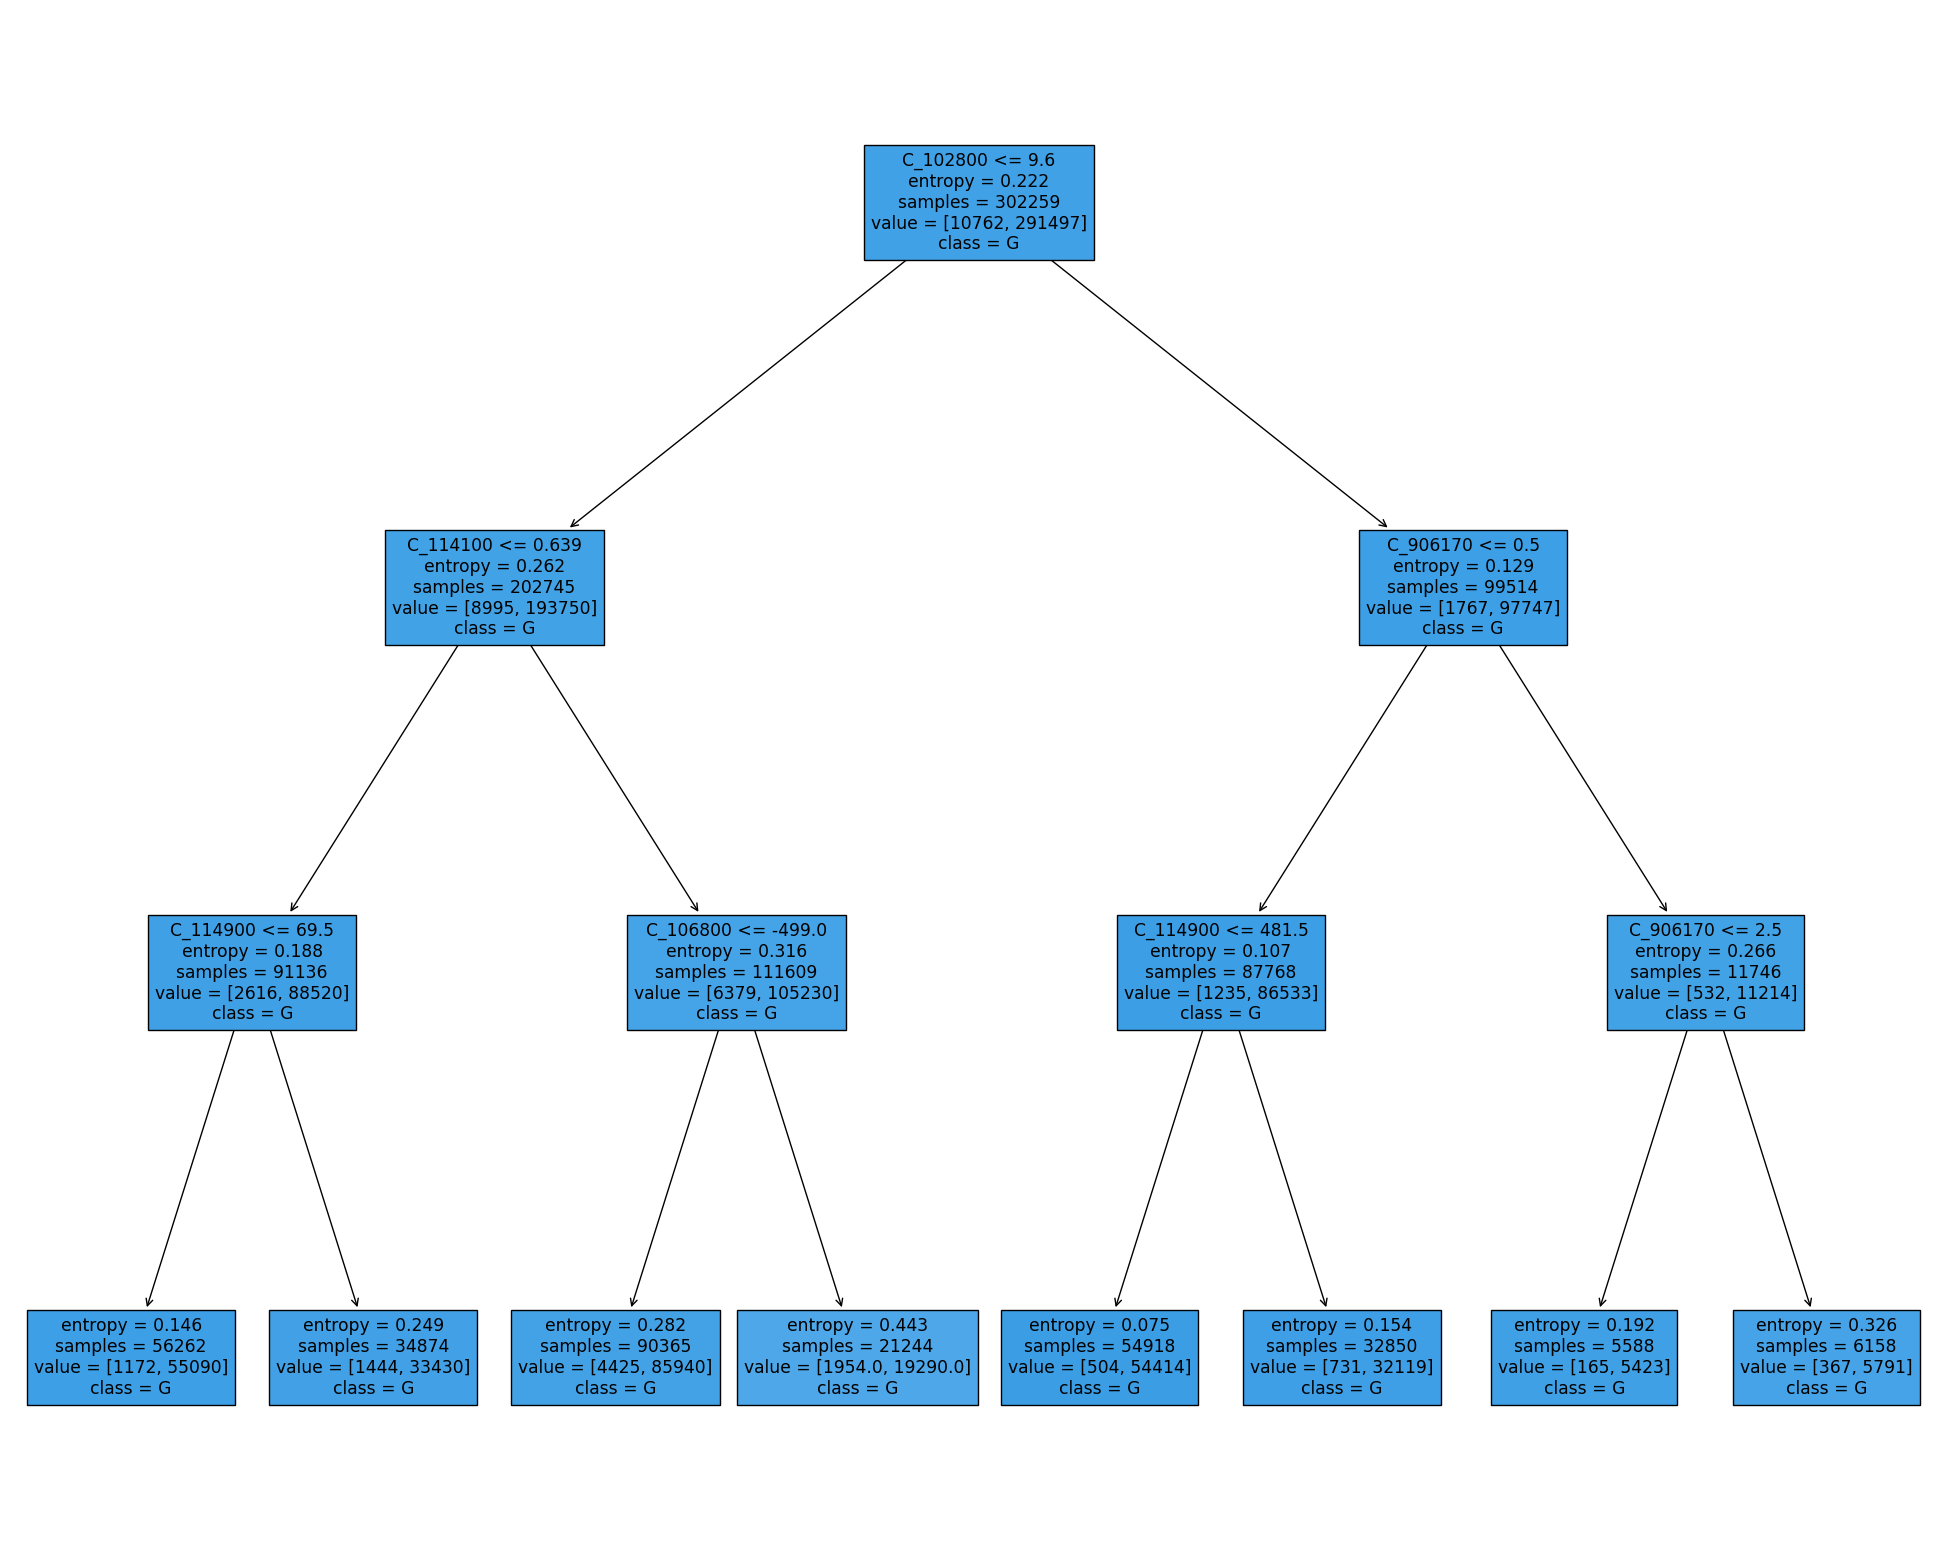

In [697]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)

#### DT pouze s produktovými proměnnými bez segmentu 1

In [513]:
product_vars = ["C_100280","C_100290","C_100300","C_100320","C_100340","performance"]

product_only_data = train_no_s_1_no_perf.loc[:,product_vars].copy()
product_only_data.loc[:,product_vars] = product_only_data.loc[:,product_vars].replace(-999, 0)

X = product_only_data.drop('performance', axis = 1)
y = product_only_data.loc[:,'performance']

In [509]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

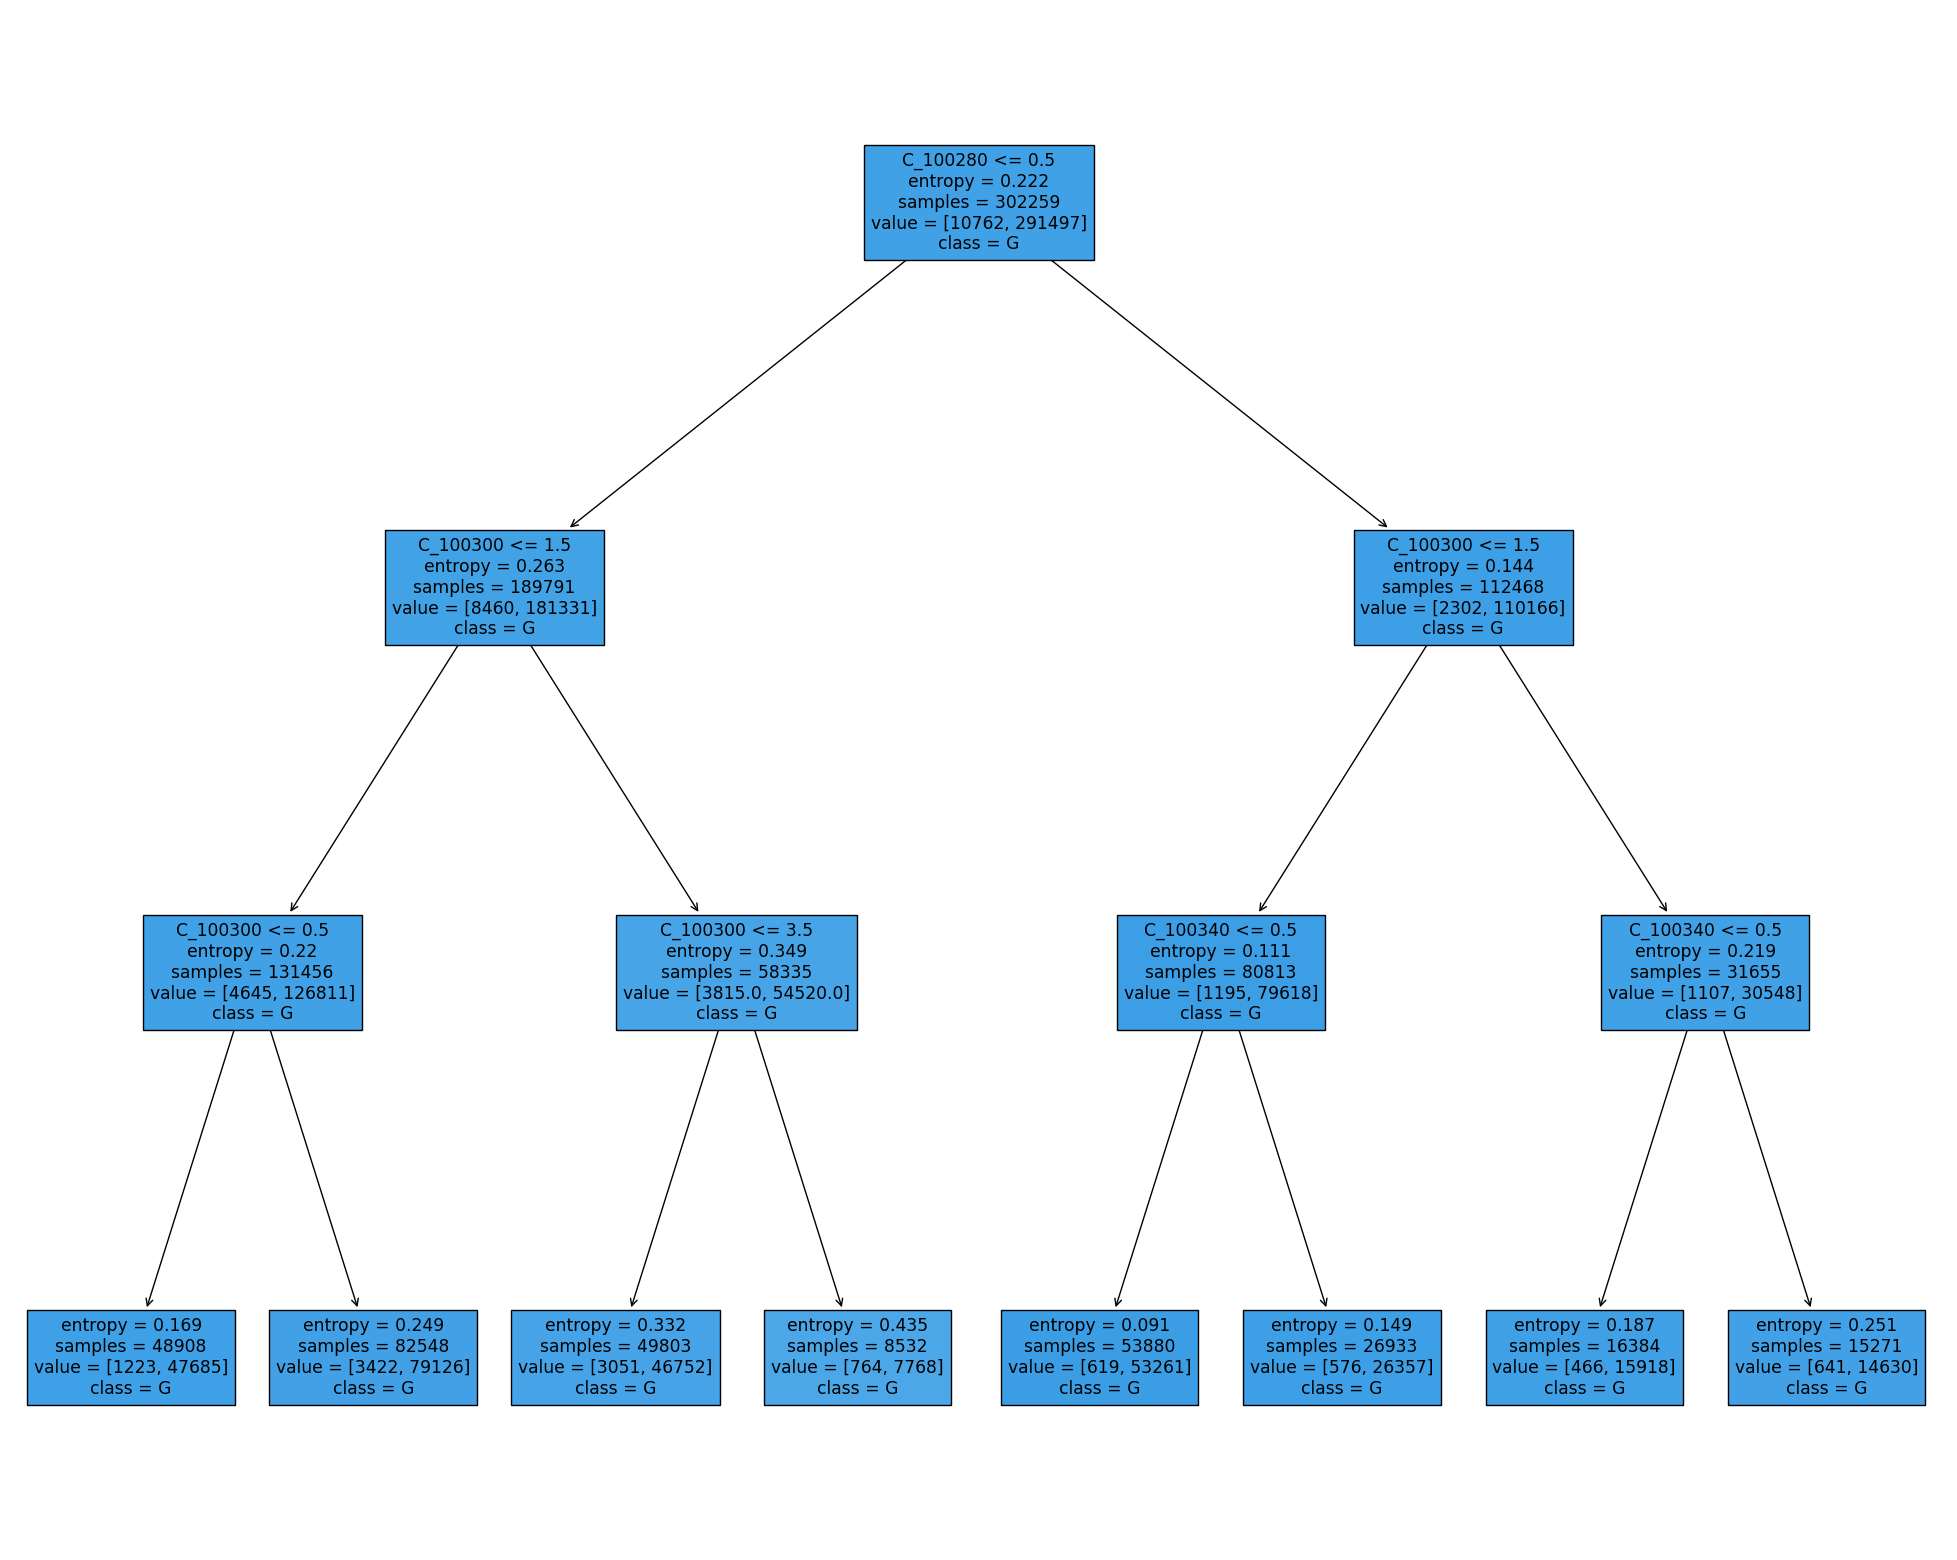

In [510]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)

###### Identifikace druhého segmentu - C_100280 > 0

#### DT bez segmentu 1 a segmentu 2

Tzn. nejsou bad (s1) a nemají žádné hypotéky (s2)

In [ ]:
#bez performance proměnných * zároveň nahradím missing product vars 0
product_vars = ["C_100280","C_100290","C_100300","C_100320","C_100340","performance"]
train_no_s1_no_s2 = train_no_s_1_no_perf.copy()
train_no_s1_no_s2.loc[:,product_vars] = train_no_s1_no_s2.loc[:,product_vars].replace(-999, 0) #převod missing product vars na 0
train_no_s1_no_s2 = train_no_s1_no_s2[train_no_s1_no_s2['C_100280'] == 0.0] #vyhození segmentu 2

In [ ]:
X = train_no_s1_no_s2.drop(['performance','C_906370'], axis = 1) # vyhazujeme proměnnou C_906370, protože je tam ve feature importance pod ní lepší - C_114593
y = train_no_s1_no_s2['performance']

In [516]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

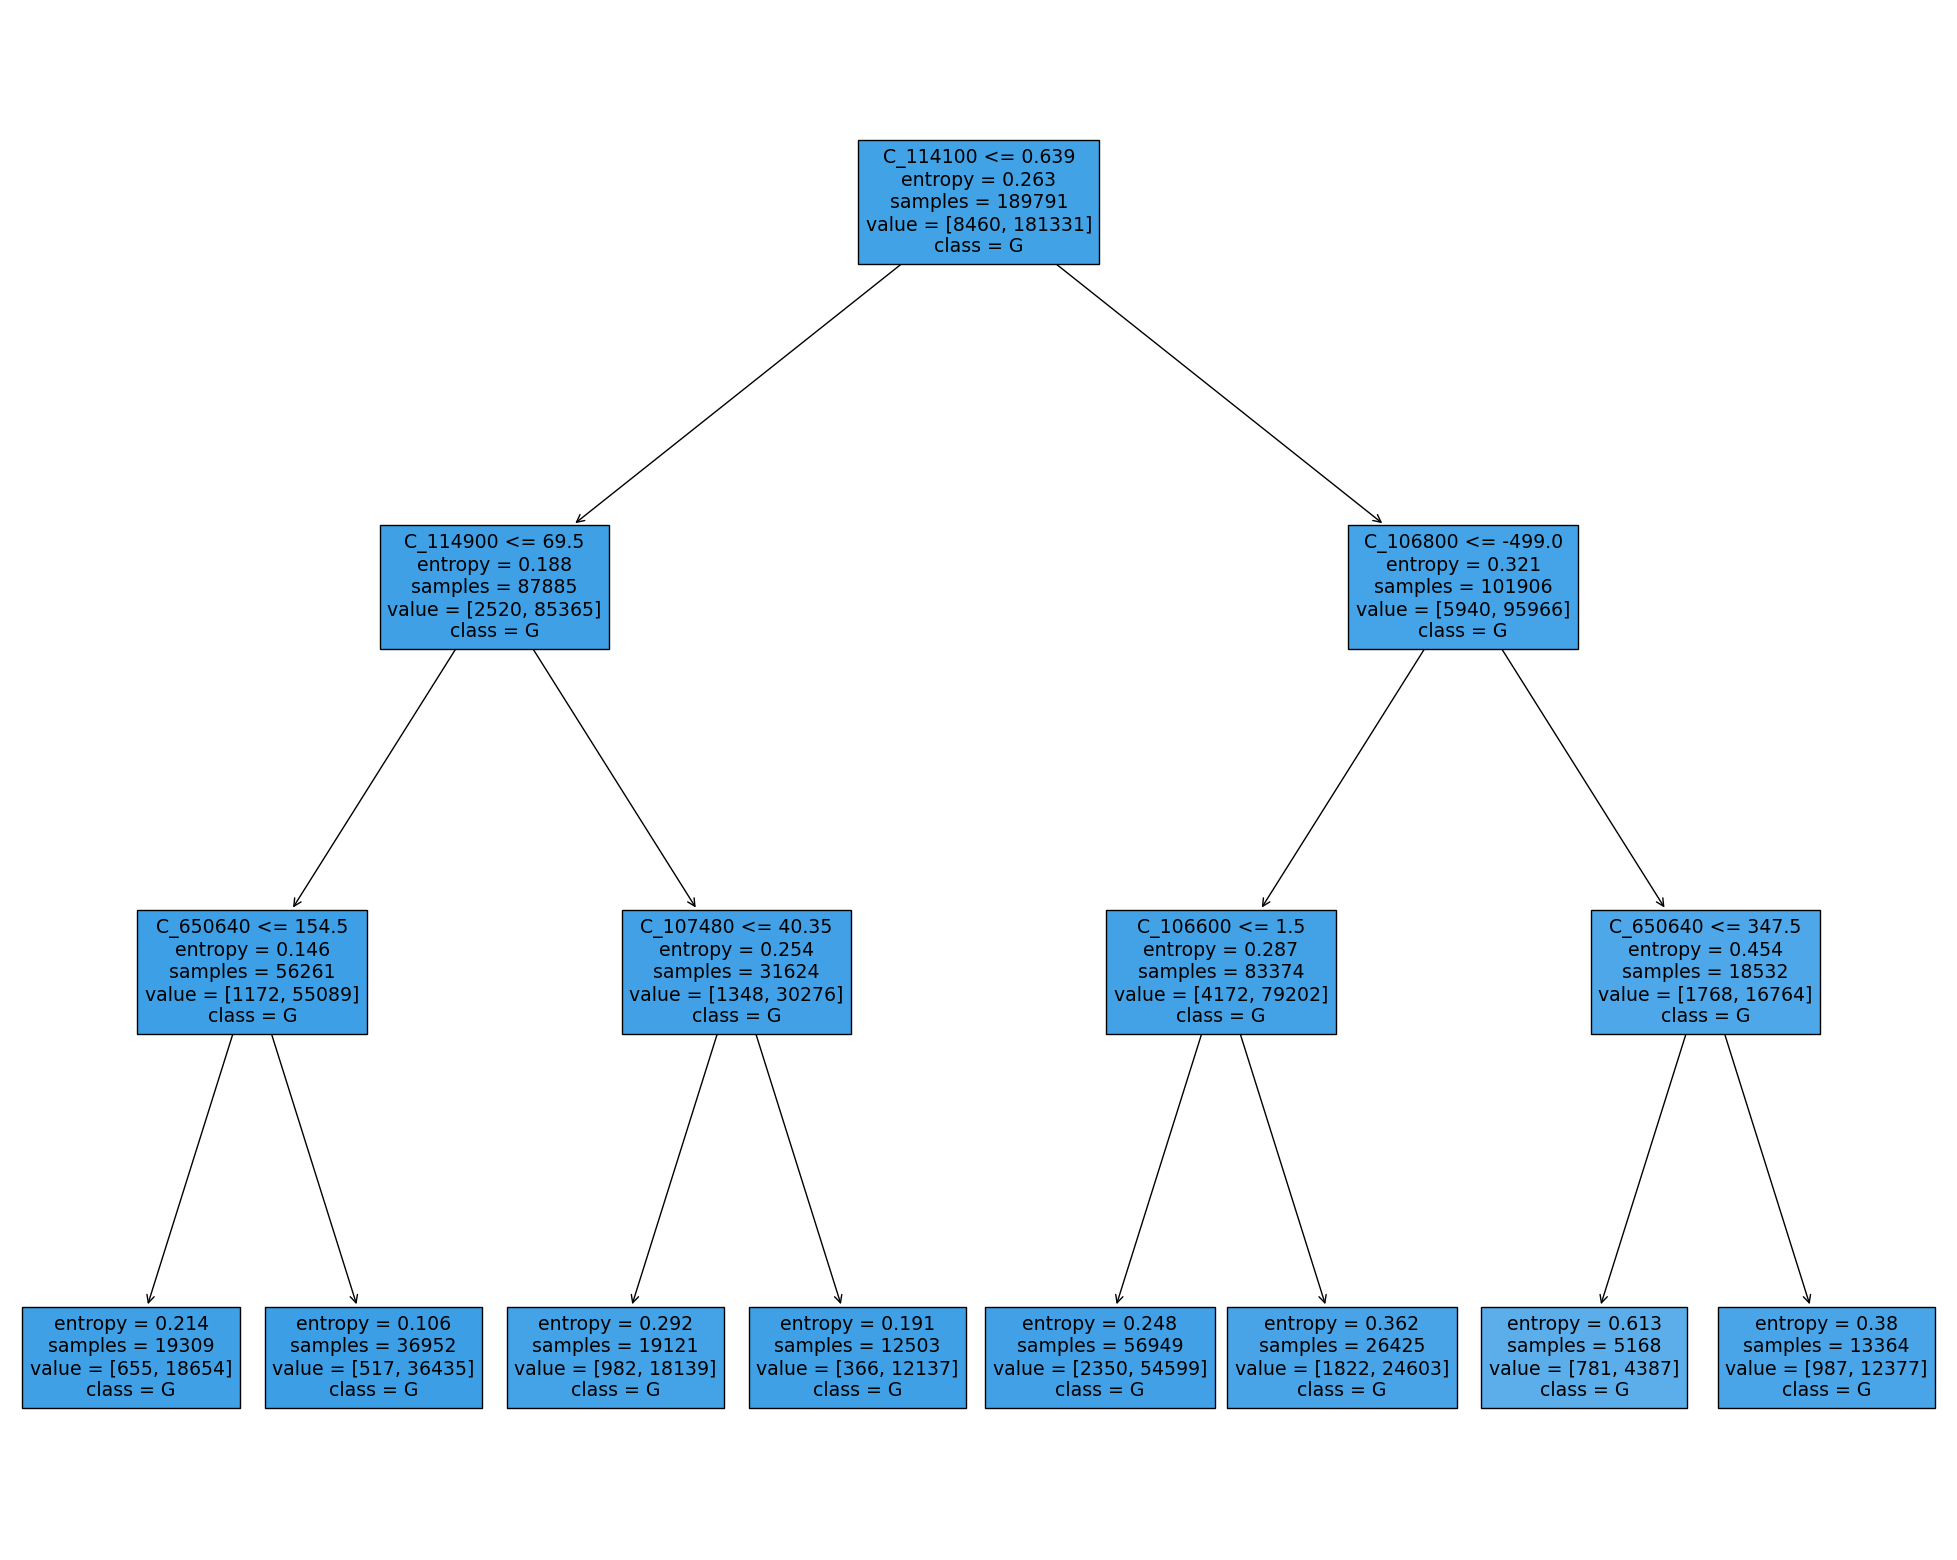

In [517]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)

###### Identifikace třetího/čtvrtého segmentu - C_114100


#### Model pouze s produktovými proměnnými - logistická regrese

Model je na datech bez prvního segmentu

In [538]:
### Data_products
selected_cols = ["C_100280","C_100290","C_100300","C_100320","C_100340","performance"]
product_cols = ["C_100280","C_100290","C_100300","C_100320","C_100340"]
train_no_s_1_no_perf_products = train_no_s_1_no_perf[selected_cols].copy()

In [ ]:
import numpy as np
#převod produktových proměnných na binary - je produkt/není produkt
def convert_to_binary(x):
    """
    Convert values to binary:
    1 for non-zero values
    0 for zero or missing values
    """
    return np.where(pd.notnull(x) & (x != 0) & (x != -999), 1, 0)

train_no_s_1_no_perf_products_binary = train_no_s_1_no_perf_products.copy()
train_no_s_1_no_perf_products_binary.loc[:,product_cols] = train_no_s_1_no_perf_products_binary.loc[:,product_cols].apply(convert_to_binary)

In [541]:
X = train_no_s_1_no_perf_products_binary.drop('performance', axis = 1)
y = train_no_s_1_no_perf_products_binary['performance']

In [ ]:
#Fit logistické regrese prostřednictím sklearn
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X, y)

LogisticRegression(random_state=42)

In [522]:
# Vytvoření DataFrame s koeficienty
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
})

# Seřazení podle absolutní hodnoty koeficientů
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("Intercept:", logreg.intercept_[0])
print("\nCoefficients:")
print(coef_df_sorted)

Intercept: 3.8811408504489013

Coefficients:
    Feature  Coefficient  Abs_Coefficient
2  C_100300    -0.798674         0.798674
0  C_100280     0.773335         0.773335
4  C_100340    -0.311132         0.311132
1  C_100290    -0.187534         0.187534
3  C_100320    -0.049819         0.049819


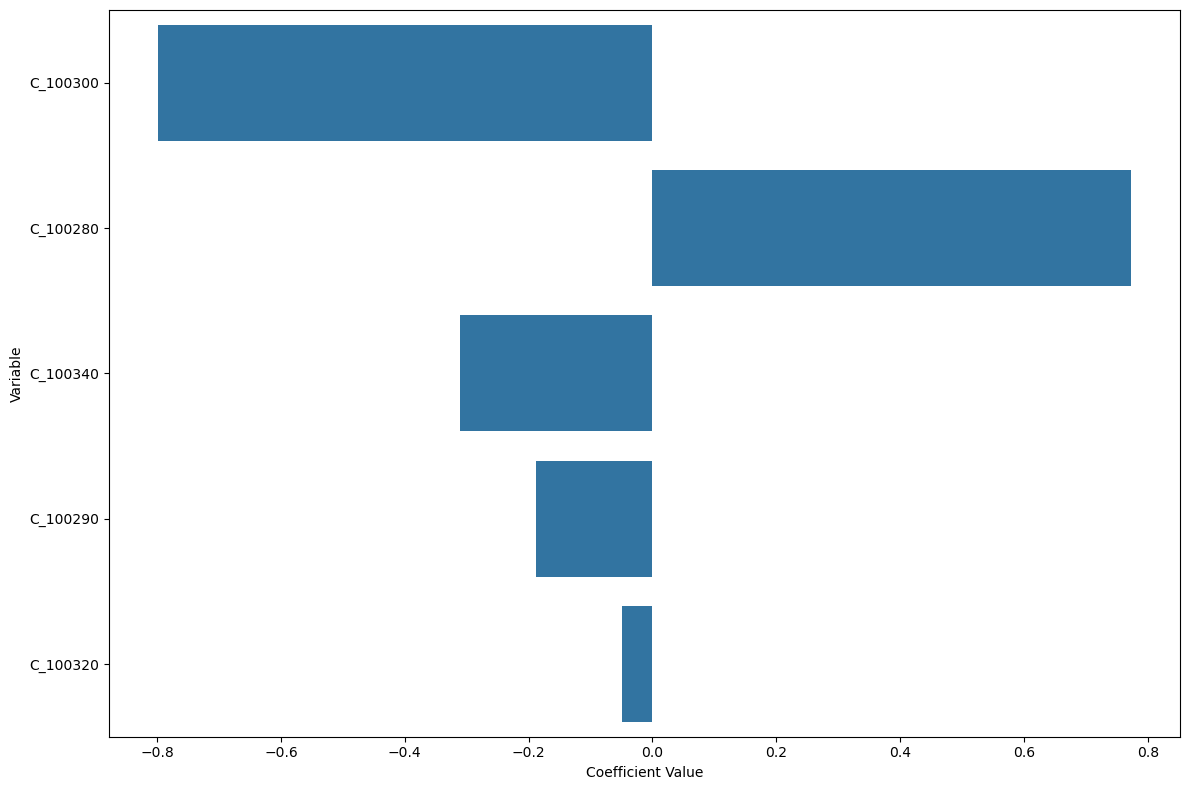

In [523]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(data=coef_df_sorted.head(20), x='Coefficient', y='Feature')
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [ ]:
# Fit logistické regrese prostřednictvím statsmodels
import statsmodels.api as sm
X_with_const = sm.add_constant(X)

In [525]:
logit_model = sm.Logit(y, X_with_const)
results = logit_model.fit()

summary_df = pd.DataFrame({
    'Feature': X_with_const.columns,
    'Coefficient': results.params,
    'Std_Error': results.bse,
    'z_value': results.tvalues,
    'P_value': results.pvalues,
    'CI_025': results.conf_int()[0],
    'CI_975': results.conf_int()[1],
    'Odds_Ratio': np.exp(results.params)
})

summary_df_sorted = summary_df.sort_values('P_value')

print("Model Summary:")
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.149361
         Iterations 8
Model Summary:
                           Logit Regression Results                           
Dep. Variable:            performance   No. Observations:               302259
Model:                          Logit   Df Residuals:                   302253
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                 0.02833
Time:                        10:38:27   Log-Likelihood:                -45146.
converged:                       True   LL-Null:                       -46462.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8759      0.029    131.419      0.000       3.818       3.934
C_100280      

### Četnosti G a B za jednotlivé produkty

bez segmentu 1

#### Mortgages

In [699]:
var_code = "C_100280"
mortgages_data = train_no_s_1_no_perf_products[[var_code,"performance"]].copy()
mortgages_data.loc[:,var_code] = mortgages_data.loc[:,var_code].replace(-999, 0)

In [700]:
mortgages_data.loc[:,"category"] = np.where((mortgages_data.loc[:,var_code]>=5),'More than 5',mortgages_data.loc[:,var_code].astype(int).astype(str))
mortgages_data.loc[:,"performance"] = mortgages_data.loc[:,"performance"].map({0: 'B', 1: 'G'})

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_13064\92708989.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G' 'G' 'G' ... 'G' 'G' 'G']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [702]:
#bad rate
frequency_table = pd.crosstab(mortgages_data['category'], mortgages_data['performance'])

# Zobrazení frekvenční tabulky
print(frequency_table)
frequency_table.to_excel('frequency_table.xlsx', sheet_name='FrequencyTable')

performance     B       G
category                 
0            8460  181331
1            1791   90361
2             376   15409
3              83    2855
4              29    1076
More than 5    23     465


#### asset finance

In [742]:
var_code = "C_100290"
af_data = train_no_s_1_no_perf_products[[var_code,"performance"]].copy()
af_data.loc[:,var_code] = af_data.loc[:,var_code].replace(-999, 0)

In [743]:
af_data.loc[:,"category"] = np.where((af_data.loc[:,var_code]>=5),'More than 5',af_data.loc[:,var_code].astype(int).astype(str))
af_data.loc[:,"performance"] = af_data.loc[:,"performance"].map({0: 'B', 1: 'G'})

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_13064\2741355520.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G' 'G' 'G' ... 'G' 'G' 'G']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [744]:
#bad rate
frequency_table = pd.crosstab(af_data['category'], af_data['performance'])

# Zobrazení frekvenční tabulky
print(frequency_table)
frequency_table.to_excel('frequency_table.xlsx', sheet_name='FrequencyTable_AF')

performance     B       G
category                 
0            7897  219915
1            2453   62174
2             259    6039
3              33    1261
4              20     595
More than 5   100    1513


#### personal loans

In [561]:
var_code = "C_100300"
loans_data = train_no_s_1_no_perf_products[[var_code,"performance"]].copy()
loans_data.loc[:,var_code] = loans_data.loc[:,var_code].replace(-999, 0)

In [562]:
loans_data.loc[:,"category"] = np.where((loans_data.loc[:,var_code]>=5),'More than 5',loans_data.loc[:,var_code].astype(int).astype(str))
loans_data.loc[:,"performance"] = loans_data.loc[:,"performance"].map({0: 'B', 1: 'G'})

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_13064\1544737500.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G' 'G' 'G' ... 'G' 'G' 'G']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [564]:
#bad rate
frequency_table = pd.crosstab(loans_data['category'], loans_data['performance'])

# Zobrazení frekvenční tabulky
print(frequency_table)
frequency_table.to_excel('frequency_table.xlsx', sheet_name='FrequencyTable')

performance     B       G
category                 
0            1701   89508
1            4139  116921
2            2672   52196
3            1218   20046
4             558    7435
More than 5   474    5391


#### non-instalment

In [565]:
var_code = "C_100340"
ni_data = train_no_s_1_no_perf_products[[var_code,"performance"]].copy()
ni_data.loc[:,var_code] = ni_data.loc[:,var_code].replace(-999, 0)

In [566]:
ni_data.loc[:,"category"] = np.where((ni_data.loc[:,var_code]>=5),'More than 5',ni_data.loc[:,var_code].astype(int).astype(str))
ni_data.loc[:,"performance"] = ni_data.loc[:,"performance"].map({0: 'B', 1: 'G'})

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_13064\789817132.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G' 'G' 'G' ... 'G' 'G' 'G']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [569]:
#bad rate
frequency_table = pd.crosstab(ni_data['category'], ni_data['performance'])

# Zobrazení frekvenční tabulky
print(frequency_table)
frequency_table.to_excel('frequency_table.xlsx', sheet_name='FrequencyTable')

performance     B       G
category                 
0            6583  197661
1            3420   80036
2             647   12033
3              96    1488
4              14     205
More than 5     2      74


#### card and revolving

In [745]:
var_code = "C_100320"
cards_data = train_no_s_1_no_perf_products[[var_code,"performance"]].copy()
cards_data.loc[:,var_code] = cards_data.loc[:,var_code].replace(-999, 0)

In [746]:
cards_data.loc[:,"category"] = np.where(cards_data.loc[:,var_code]>=5,'More than 5',cards_data.loc[:,var_code].astype(int).astype(str))
cards_data.loc[:,"performance"] = cards_data.loc[:,"performance"].apply(lambda x: 'B' if x == 0 else 'G')

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_13064\1174998763.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G' 'G' 'G' ... 'G' 'G' 'G']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [747]:
#bad rate
frequency_table = pd.crosstab(cards_data['category'], cards_data['performance'])

# Zobrazení frekvenční tabulky
print(frequency_table)
frequency_table.to_excel('frequency_table.xlsx', sheet_name='FrequencyTable')

performance     B       G
category                 
0            4304  120693
1            3670  109390
2            1911   44504
3             613   12695
4             181    3258
More than 5    83     957


### Počty G a B a BR v segmentech


#### train data

In [707]:
seg1 = train[train['C_500600'] != 0]
seg1['performance'].value_counts()

performance
1    9679
0    7807
Name: count, dtype: int64

In [708]:
seg2 = train[(train['C_500600'] == 0) & (train['C_100280']>0)]
seg2['performance'].value_counts()

performance
1    110166
0      2302
Name: count, dtype: int64

In [719]:
#seg3
seg3 = train[(train['C_500600'] == 0) & (train['C_100280']<=0) & (train['C_114100']<=0.64)]
seg3['performance'].value_counts()

performance
1    85475
0     2526
Name: count, dtype: int64

In [720]:
#seg4
seg4 = train[(train['C_500600'] == 0) & (train['C_100280']<=0) & (train['C_114100']>0.64)]
seg4['performance'].value_counts()

performance
1    95856
0     5934
Name: count, dtype: int64

#### test data

In [721]:
seg1 = test[test['C_500600'] != 0]
seg1['performance'].value_counts()

performance
1    4197
0    3376
Name: count, dtype: int64

In [722]:
seg2 = test[(test['C_500600'] == 0) & (test['C_100280']>0)]
seg2['performance'].value_counts()

performance
1    47238
0      975
Name: count, dtype: int64

In [723]:
#seg3
seg3 = test[(test['C_500600'] == 0) & (test['C_100280']<=0) & (test['C_114100']<=0.64)]
seg3['performance'].value_counts()

performance
1    36610
0     1140
Name: count, dtype: int64

In [724]:
#seg4
seg4 = train[(train['C_500600'] == 0) & (train['C_100280']<=0) & (train['C_114100']>0.64)]
seg4['performance'].value_counts()

performance
1    95856
0     5934
Name: count, dtype: int64

#### total

In [725]:
seg1 = df_imp[df_imp['C_500600'] != 0]
seg1['performance'].value_counts()

performance
1    13876
0    11183
Name: count, dtype: int64

In [727]:
seg2 = df_imp[(df_imp['C_500600'] == 0) & (df_imp['C_100280']>0)]
seg2['performance'].value_counts()

performance
1    157404
0      3277
Name: count, dtype: int64

In [728]:
#seg3
seg3 = df_imp[(df_imp['C_500600'] == 0) & (df_imp['C_100280']<=0) & (df_imp['C_114100']<=0.64)]
seg3['performance'].value_counts()

performance
1    122085
0      3666
Name: count, dtype: int64

In [729]:
#seg4
seg4 = df_imp[(df_imp['C_500600'] == 0) & (df_imp['C_100280']<=0) & (df_imp['C_114100']>0.64)]
seg4['performance'].value_counts()

performance
1    136810
0      8478
Name: count, dtype: int64

#### Celý dataset - i s ostatními performance hodnotami

In [730]:
all_st = pd.read_sas("data_all_perf_st.sas7bdat")
all_mw = pd.read_sas("data_all_perf_wi.sas7bdat")

In [731]:
#převod bytes to strings
columns_to_convert = ["CBSMessageId","C_600570","C_660570","C_500300","C_500600","C_501200","C_502400","performance"]
def convert_bytes_to_str(x):
    return x.decode('utf-8') if isinstance(x, bytes) else x
all_st[columns_to_convert] = all_st[columns_to_convert].map(convert_bytes_to_str)
all_mw[columns_to_convert] = all_mw[columns_to_convert].map(convert_bytes_to_str)

#### mw

In [732]:
seg1 = all_mw[(all_mw['C_500600'].isin(['B','I']))]
seg1['performance'].value_counts()

performance
G    13876
I    13525
B    11183
N     1826
O     1077
Name: count, dtype: int64

In [733]:
seg2 = all_mw[(all_mw['C_500600'] == 'G') & (all_mw['C_100280']>0)]
seg2['performance'].value_counts()

performance
G    157111
I      6558
B      3271
O       217
N        53
Name: count, dtype: int64

In [734]:
#seg3
seg3 = all_mw[(all_mw['C_500600'] == 'G') & ((all_mw['C_100280'] <= 0) | (all_mw['C_100280'].isnull())) & (all_mw['C_114100'] <= 0.64)]
seg3['performance'].value_counts()

performance
G    108060
I      4781
O      4510
B      3141
N       133
Name: count, dtype: int64

In [737]:
#seg4
seg4 = all_mw[(all_mw['C_500600'] == 'G') & ((all_mw['C_100280'] <= 0) | (all_mw['C_100280'].isnull())) & (all_mw['C_114100'] > 0.64)]
seg4['performance'].value_counts()

performance
G    136787
I      9778
B      8470
O      2213
N        31
Name: count, dtype: int64

#### st

In [738]:
seg1 = all_st[(all_st['C_500600'].isin(['B','I']))]
seg1['performance'].value_counts()

performance
N    69831
G     1036
O      602
B       25
I       19
Name: count, dtype: int64

In [739]:
seg2 = all_st[(all_st['C_500600'] == 'G') & (all_st['C_100280']>0)]
seg2['performance'].value_counts()

performance
N    144594
G     28116
O      7484
B        90
I        76
Name: count, dtype: int64

In [740]:
#seg3
seg3 = all_st[(all_st['C_500600'] == 'G') & ((all_st['C_100280'] <= 0) | (all_st['C_100280'].isnull())) & (all_st['C_114100'] <= 0.64)]
seg3['performance'].value_counts()

performance
N    95770
G    21588
O     5304
B      515
I      253
Name: count, dtype: int64

In [741]:
#seg4
seg4 = all_st[(all_st['C_500600'] == 'G') & ((all_st['C_100280'] <= 0) | (all_st['C_100280'].isnull())) & (all_st['C_114100'] > 0.64)]
seg4['performance'].value_counts()

performance
N    152149
G     25354
O      5545
B      1313
I       490
Name: count, dtype: int64